In [ ]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.cloud import bigquery as bq
import statsmodels.api as sm
import matplotlib

# Initialize a BigQuery Client
client = bq.Client.from_service_account_json('/Users/jharding/repos/SMU-DS-6372/ml-jth-d220ef33563e.json')

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


# BigQuery Data Load (Do Not Run)
## Functions
### Extract .txt File Function

In [ ]:
### Extract data file from zip files

def extract_txt(path, storage_path, f):
    # Now change the directory
    os.chdir( path )
    import zipfile
    zipfile.ZipFile
    #print(f)
    my_zip = zipfile.ZipFile(f) # Specify your zip file's name here
    storage_path = storage_path
    for file in my_zip.namelist():
        #if my_zip.getinfo(file).filename.endswith('.txt'):
        if my_zip.getinfo(file).filename.startswith('produkt'):
            print("unzipping:", file)
            my_zip.extract(file, storage_path)
        

### BigQuery Load Procedure

In [ ]:
def load_bq(dataset, table, data):
    client = bq.Client.from_service_account_json('/Users/jharding/repos/SMU-DS-6372/ml-jth-d220ef33563e.json')
    dataset_id = dataset
    
    dataset_ref = client.dataset(dataset_id)
    table_ref = table
    
    job_config=bq.LoadJobConfig()
    job_config.schema = [
        bq.SchemaField('StationID', 'INTEGER'),
        bq.SchemaField('Date', 'DATE'),
        bq.SchemaField('QN3',  'INTEGER'),
        bq.SchemaField('MaxWindGust', 'FLOAT64'),
        bq.SchemaField('MeanWindSpeed', 'FLOAT64'),
        bq.SchemaField('QN4', 'INT64'),
        bq.SchemaField('PrecipHeight', 'FLOAT64'),
        bq.SchemaField('PrecipForm', 'INT64'),
        bq.SchemaField('SunDuration', 'FLOAT64'),
        bq.SchemaField('SnowDepth', 'INT64'),
        bq.SchemaField('MeanCloudCover', 'FLOAT64'),
        bq.SchemaField('MeanCloudVapor', 'FLOAT64'),
        bq.SchemaField('MeanPressure', 'FLOAT64'),
        bq.SchemaField('MeanTemp', 'FLOAT64'),
        bq.SchemaField('MeanRelHumid', 'FLOAT64'),
        bq.SchemaField('MaxTemp', 'FLOAT64'),
        bq.SchemaField('MinTemp', 'FLOAT64'),
        bq.SchemaField('MinAirTemp', 'FLOAT64')  
    ]
    
    uri = data
                       
    load_job = client.load_table_from_dataframe(
        uri,
        dataset_ref.table(table_ref),
        job_config=job_config)
    
    print('Starting job{}',format(load_job.job_id))
    
    load_job.result()
    print('Job Finished\n')
    

### Panda Dataframe Function

In [ ]:
def extract_data(file):
    test = pd.read_csv(file,sep=';')
    test.columns = ['StationID','DateTime','QN3','MaxWindGust',
                'MeanWindSpeed','QN4','PrecipHeight','PrecipForm',
                'SunDuration', 'SnowDepth', 'MeanCloudCover',
                'MeanCloudVapor', 'MeanPressure','MeanTemp',
                'MeanRelHumid','MaxTemp','MinTemp','MinAirTemp','eor']

    ## Change to Date Format
    dateFormat = '%Y%m%d'
    test['DateTime'] = pd.to_datetime(test['DateTime'], format=dateFormat)
    test['Date']=test['DateTime'].dt.date
    
    ## Drop unneeded columns
    test.drop(['eor','DateTime'], axis=1, inplace=True)
    
    ## Force dataframe to Float64
    test['MaxWindGust'] = test['MaxWindGust'].astype(np.float64)
    test['MeanPressure'] = test['MeanPressure'].astype(np.float64)
    test['MeanWindSpeed'] = test['MeanWindSpeed'].astype(np.float64)
    test['MinAirTemp'] = test['MinAirTemp'].astype(np.float64)
    test['PrecipHeight'] = test['PrecipHeight'].astype(np.float64)
    test['SunDuration'] = test['SunDuration'].astype(np.float64)
    test['MeanCloudCover'] = test['MeanCloudCover'].astype(np.float64)
    test['MeanCloudVapor'] = test['MeanCloudVapor'].astype(np.float64)
    test['MeanTemp'] = test['MeanTemp'].astype(np.float64)
    test['MeanRelHumid'] = test['MeanRelHumid'].astype(np.float64)
    test['MaxTemp'] = test['MaxTemp'].astype(np.float64)
    test['MinTemp'] = test['MinTemp'].astype(np.float64)
    
    print("Preparing to load:",file)
    load_bq('germany', 'weather', test)


### Get ZipFile List Function

In [ ]:
### Get all of the zip files and put them in a list

from __future__ import print_function
import os

def get_file(path, ext):
    z=[]   
    files = os.listdir(path)
    for name in files:
        if name.endswith(ext):
            z.append(name)
    return z
            



## Extract Text Files

In [ ]:
## Set Path
storage_path = '/Users/jharding/repos/SMU-DS-6372/project/DS6372/data/dest/'
path = '/Users/jharding/repos/SMU-DS-6372/project/DS6372/data/zip/'

## Get list of zip files.
z = get_file(path, '.zip')

## For each zip file, extract text file.
path = '/Users/jharding/repos/SMU-DS-6372/project/DS6372/data/zip/'
for file in z:
    extract_txt(path, storage_path, file)
    



### Get and Sort Text File List

In [ ]:
#### Load txt files
path = '/Users/jharding/repos/SMU-DS-6372/project/DS6372/data/dest'
os.chdir( path )
t = get_file(path, '.txt')
t.sort()
t

## Load Data into BQ

In [ ]:
for file in t:
    extract_data(file)

# Weather Stations

In [ ]:
stations = pd.read_csv("./data/WeatherStationsGermany.csv")
stations.head()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
#Creating a GeoDataFrame from a DataFrame with coordinates


## A GeoDataFrame needs a shapely object, so we create a new column Coordinates 
## as a tuple of Longitude and Latitude :
stations['Coordinates'] = list(zip(stations.Longitude, stations.Latitude))

## Then, we transform tuples to Point :
stations['Coordinates'] = stations['Coordinates'].apply(Point)

# Now, we can create the GeoDataFrame by setting geometry with the coordinates created previously.
gdf = gpd.GeoDataFrame(stations, geometry='Coordinates')
print(gdf.head())

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world[world['name'] == 'Germany'].plot(color='white', edgecolor='black', figsize=(20,20))
gdf.plot(ax=base, color='red')
plt.show()

In [ ]:
world.plot(figsize=(20,20))

# Weather EDA

In [ ]:
## Calculat the percentage of null values.  
## Null values set to -999.0
def pct_null(x):
    print(x,":", ((df[df[x]== -999][x].count())/df[x].count())*100, "Pct Null")

def plot_hist(x):
    df[df[x]> -999][x].hist(bins=30)


In [ ]:
## Define the query'
## MaxWindGust: All values are -999.0.  Remove from query
## MeanWindSpeed: All values are -999.0.  Remove from query

### This will be our Test Data
QUERY = """
        SELECT StationID, Date, MinTemp, MaxTemp, MeanTemp,
        MinAirTemp, SunDuration, MeanCloudCover, MeanCloudVapor, 
        MeanRelHumid, PrecipHeight, PrecipForm, MeanPressure, 
        SnowDepth
        FROM `ml-jth.germany.weather`
        WHERE date > "1939-09-01" and date < "1945-06-01"
        and StationID IN (1,2,3,4,5)
        order by StationID, Date
        """
query_job = client.query(QUERY)
df = query_job.to_dataframe()


### Training Data 
QUERY2 = """
        SELECT StationID, Date, MinTemp, MaxTemp, MeanTemp,
        MinAirTemp, SunDuration, MeanCloudCover, MeanCloudVapor, 
        MeanRelHumid, PrecipHeight, PrecipForm, MeanPressure, 
        SnowDepth
        FROM `ml-jth.germany.weather`
        WHERE date > "1929-09-01" and date < "1939-09-01"
        order by StationID, Date
        """

In [ ]:
## Convert Temps to Farenheit
## Replace w/BQ Function
df['MaxTemp'] = df['MaxTemp'].apply(lambda x: int((x * 9/5) + 32))
df['MinTemp'] = df['MinTemp'].apply(lambda x: int((x * 9/5) + 32))
df['MeanTemp'] = df['MeanTemp'].apply(lambda x: int((x * 9/5) + 32))
df['MinAirTemp'] = df['MinAirTemp'].apply(lambda x: int((x * 9/5) + 32))
df.loc[df['MaxTemp']<=-999.0, ['MaxTemp']]= -999.0
df.loc[df['MinTemp']<=-999.0, ['MinTemp']]= -999.0
df.loc[df['MeanTemp']<=-999.0, ['MeanTemp']]= -999.0
df.loc[df['MinAirTemp']<=-999.0, ['MinAirTemp']]= -999.0

df.head(3)

In [ ]:
## Get the number of columns and rows
df.shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
features = ['MinTemp','MaxTemp','MeanTemp','MinAirTemp','SunDuration',
            'MeanCloudCover','MeanCloudVapor','MeanRelHumid','PrecipHeight','PrecipForm','MeanPressure','SnowDepth']

x = df.loc[:, features].values

In [ ]:
### How many null columns
df.isnull().sum()

In [ ]:
### Are there particular stations that can be ommitted
stations = df.groupby('StationID')

In [ ]:
## Iterate over list to get pct of nulls
## Nulls determined by value = -999.0
### Remove MaxWindGust
### Remove MeanWindSpeed

col = iter(list(['MinTemp', 'MaxTemp', 'MeanTemp', 'MinAirTemp',
                 'SunDuration', 'MeanCloudVapor','MeanCloudCover',
                 'MeanRelHumid', 'PrecipHeight', 'PrecipForm', 
                 'MeanPressure', 'SnowDepth'
                ]))

for i in col:
    pct_null(i)

In [ ]:
# What is the distribution of WeatherStations
num_bins = 30
plt.hist(df['StationID'], num_bins, density=1, facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
#pd.options.display.mpl_style = 'default'
df.hist(figsize=(15,10))

## Closer Look at Variables 
### MaxTemp

In [ ]:
x = 'MaxTemp'
pct_null(x)
plot_hist(x)

### MinTemp

In [ ]:
# Daily MinTemp - %
x = 'MinTemp'
pct_null(x)
plot_hist(x)

### MeanTemp

In [ ]:
# Daily MeanTemp - %F
x = 'MeanTemp'
pct_null(x)
plot_hist(x)

### TempCategories

In [ ]:
def get_stats(group):
    return {'a_min': group.min(), 'b_max': group.max(), 'd_count': group.count(), 'c_mean': group.mean()}

bins = [0, 32, 45,60, 74, 120]
group_names = ['Freezing','Cold','Mild','Warm','Hot']

#### MaxTemp Categories

In [ ]:
df['MaxTempCat'] = pd.cut(df['MaxTemp'], bins, labels=group_names)
df['MaxTemp'].groupby(df['MaxTempCat']).apply(get_stats).unstack()

#### MinTemp Category

In [ ]:
df['MinTempCat'] = pd.cut(df['MinTemp'], bins, labels=group_names)
df['MinTemp'].groupby(df['MinTempCat']).apply(get_stats).unstack()

#### MeanTemp Cateogory

In [ ]:
df['MeanTempCat'] = pd.cut(df['MeanTemp'], bins, labels=group_names)
df['MeanTemp'].groupby(df['MeanTempCat']).apply(get_stats).unstack()

###  MaxCloudCover

In [ ]:
x = 'MeanCloudCover'
pct_null(x)
plot_hist(x)

### PrecipHeight

In [ ]:
x = 'PrecipHeight'
pct_null(x)
plot_hist(x)

### PrecipForm

In [ ]:
# 0 - no precipitation 
# 1 - only rain (before 1979)
# 4 - unknown form of recorded precipitation
# 6 - only rain; only liquid precipitation at automatic stations
# 7 - only snow; only solid precipitation at automatic stations
# 8 - rain and snow (and/or "Schneeregen"); liquid and solid precipitation at automatic stations
# 9 - error or missing value or no automatic determination of precipitation form
x='PrecipForm'
pct_null(x)
plot_hist(x)

### SunDuration

In [ ]:
# Daily Sun duration - Hours
x = 'SunDuration'
pct_null(x)
plot_hist(x)

In [ ]:
SunDuration_Null = df[df.SunDuration == -999].groupby(['StationID'])['SunDuration'].count()
print(SunDuration_Null)

In [ ]:
#df[df.StationID == 314].groupby(['StationID'])['MaxTemp'].count()
col = list(SunDuration_Null.index)
col = iter(list(SunDuration_Null.index))

for i in col:
    temp = df[df.StationID == i].groupby(['StationID'])['SunDuration'].count()
    print(i,temp.values)
#MaxTemp_Null.index

In [ ]:
#stations.agg({'SunDuration':[min,max,"std","mean","count"]})

### SnowDepth

In [ ]:
# Daily SnowDepth - cm
x = 'SnowDepth'
pct_null(x)
plot_hist(x)

In [ ]:
df['SnowDepth'].describe()

### MeanCloudCover

In [ ]:
# Daily MeanCloudCover - 1/8
x = 'MeanCloudCover'
pct_null(x)
plot_hist(x)

### MeanCloudVapor

In [ ]:
# Daily MeanCloudVapor - hPA
x = 'MeanCloudVapor'
pct_null(x)
plot_hist(x)

### MeanPressure

In [ ]:
# Daily MeanPressure - hPA
x = 'MeanPressure'
pct_null(x)
plot_hist(x)

### MeanRelHumid

In [ ]:
# Daily MeanRelHumid - %
x = 'MeanRelHumid'
pct_null(x)
plot_hist(x)

### [Scatter Plots](https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/)

In [ ]:
# split data table into data X and class labels y

X = df.iloc[:,0:4].values
y = df.iloc[:,4].values

# [ARIMA Time Series Analysis](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

In [ ]:
### Pull the pre-war data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.cloud import bigquery as bq

# Initialize a BigQuery Client
client = bq.Client.from_service_account_json('/Users/jharding/repos/SMU-DS-6372/ml-jth-d220ef33563e.json')
#from bq_helper import BigQueryHelper

query_job = client.query(QUERY2)
df = query_job.to_dataframe()


### Analyze one Station
QUERY2 = """
        SELECT MeanCloudCover, Date, MinTemp, MaxTemp, MeanTemp,
        MinAirTemp, SunDuration,  MeanCloudVapor, 
        MeanRelHumid, PrecipHeight, PrecipForm, MeanPressure, 
        SnowDepth,  StationID
        FROM `ml-jth.germany.weather`
        WHERE date > "1929-09-01" and date < "1955-09-01"
        and StationID in (1,2,3,4,5)
        order by Date
        """
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
query_job = client.query(QUERY2)
df_pre = query_job.to_dataframe()


In [285]:
##
df_pre.shape

(15461, 2)

In [ ]:
dateFormat = '%Y-%m-%d'
df_pre['Date'] = pd.to_datetime(df_pre['Date'], format=dateFormat)
#df_pre['Date'] = df_pre['Date'].dt.date

In [ ]:
#This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

cols = ['MinTemp', 'MaxTemp', 'MeanTemp',
        'MinAirTemp', 'SunDuration',  'MeanCloudVapor', 
        'MeanRelHumid', 'PrecipHeight', 'PrecipForm', 'MeanPressure', 
        'SnowDepth',  'StationID']
df_pre.drop(cols, axis=1, inplace=True)
df_pre = df_pre.sort_values('Date')

df_pre.isnull().sum()

In [ ]:
df = df_pre.groupby('Date')['MeanCloudCover'].sum().reset_index()

In [ ]:
df = df_pre.set_index('Date')
df.index

In [286]:
# Use average cloud cover per day
y = df['MeanCloudCover'].resample('MS').mean()

In [ ]:
df.index

In [ ]:
ts = df['MeanCloudCover']
ts.head(10)

In [ ]:
y.plot(figsize=(15,6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, nforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

In [ ]:
# Fitting the model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
# We should always run model diagnostics to investigate any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
# Validating Forecast
pred = results.get_prediction(start=pd.to_datetime('1936-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['1930':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean Cloud Cover')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['1936-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 2.75

In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily cloud cover in the test set within 2.75 of the real cloud coverage. Our daily cloud coverage range from 1 to 8. In my opinion, this is a pretty bad model so far.

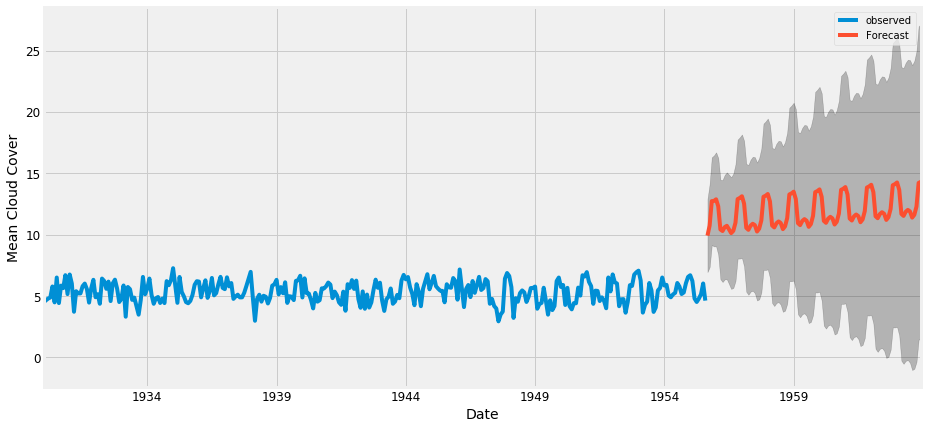

In [276]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Mean Cloud Cover')
plt.legend()
plt.show()

# Univariate: LSTM Recurrent Neural Networks

Time series prediction problems are a difficult type of predictive modeling problem.

Unlike regression predictive modeling, time series also adds the complexity of a sequence dependence among the input variables.

A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained.

In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
"""
Before we do anything, it is a good idea to fix the random 
number seed to ensure our results are reproducible.
"""


# fix random seed for reproducibility
np.random.seed(7)


In [288]:
a = np.array(y.values.tolist())
data_tuples = list(zip(a))
new_df = pd.DataFrame(data_tuples,columns=['MCC'])
new_df.head()

,MCC
0,4.506452
1,4.660714
2,4.800000
3,4.883333
4,5.783871


In [338]:
dataset = new_df.values
dataset = dataset.astype('float32')

In [339]:
scaler = MinMaxScaler(feature_range=(1, 8))
dataset = scaler.fit_transform(dataset)

In [340]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

206 102


In [341]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [342]:
# reshape into X=t and Y=t+1
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [343]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [344]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(18, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 10.6544
Epoch 2/100
 - 0s - loss: 1.9610
Epoch 3/100
 - 0s - loss: 1.6560
Epoch 4/100
 - 0s - loss: 1.6327
Epoch 5/100
 - 0s - loss: 1.6115
Epoch 6/100
 - 0s - loss: 1.6156
Epoch 7/100
 - 0s - loss: 1.5964
Epoch 8/100
 - 0s - loss: 1.5684
Epoch 9/100
 - 0s - loss: 1.5800
Epoch 10/100
 - 0s - loss: 1.5329
Epoch 11/100
 - 0s - loss: 1.5310
Epoch 12/100
 - 0s - loss: 1.5254
Epoch 13/100
 - 0s - loss: 1.5082
Epoch 14/100
 - 0s - loss: 1.5040
Epoch 15/100
 - 0s - loss: 1.4904
Epoch 16/100
 - 0s - loss: 1.4894
Epoch 17/100
 - 0s - loss: 1.4748
Epoch 18/100
 - 0s - loss: 1.4927
Epoch 19/100
 - 0s - loss: 1.4908
Epoch 20/100
 - 0s - loss: 1.4650
Epoch 21/100
 - 0s - loss: 1.4728
Epoch 22/100
 - 0s - loss: 1.4547
Epoch 23/100
 - 0s - loss: 1.4736
Epoch 24/100
 - 0s - loss: 1.4822
Epoch 25/100
 - 0s - loss: 1.4527
Epoch 26/100
 - 0s - loss: 1.4288
Epoch 27/100
 - 0s - loss: 1.4005
Epoch 28/100
 - 0s - loss: 1.4413
Epoch 29/100
 - 0s - loss: 1.4296
Epoch 30/100
 - 0s - l

In [345]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.68 RMSE
Test Score: 0.89 RMSE


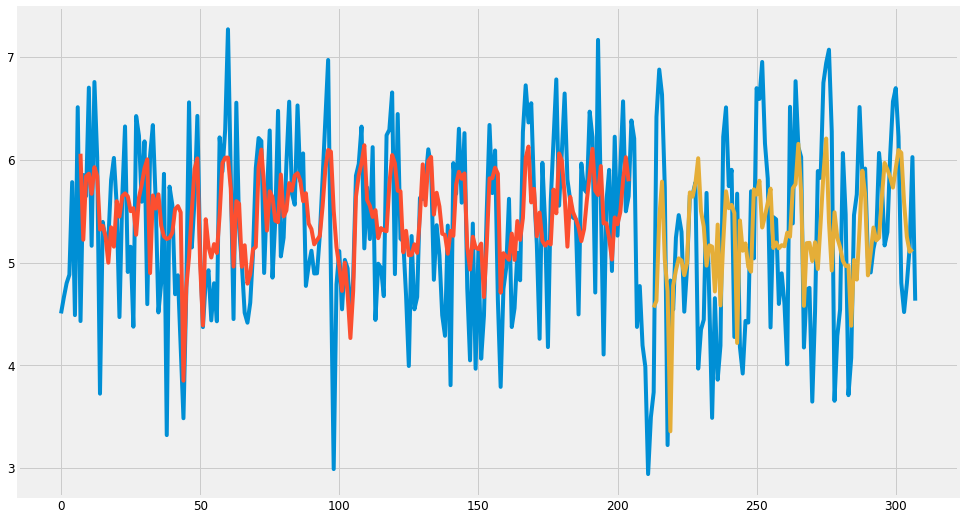

In [346]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15,9))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

LSTM for Regression Using the Window Method

In [347]:
dataset = new_df.values
dataset = dataset.astype('float32')

Epoch 1/100
 - 2s - loss: 0.1246
Epoch 2/100
 - 0s - loss: 0.0424
Epoch 3/100
 - 0s - loss: 0.0407
Epoch 4/100
 - 0s - loss: 0.0392
Epoch 5/100
 - 0s - loss: 0.0391
Epoch 6/100
 - 0s - loss: 0.0375
Epoch 7/100
 - 0s - loss: 0.0370
Epoch 8/100
 - 0s - loss: 0.0360
Epoch 9/100
 - 0s - loss: 0.0351
Epoch 10/100
 - 0s - loss: 0.0350
Epoch 11/100
 - 0s - loss: 0.0346
Epoch 12/100
 - 0s - loss: 0.0340
Epoch 13/100
 - 0s - loss: 0.0341
Epoch 14/100
 - 0s - loss: 0.0335
Epoch 15/100
 - 0s - loss: 0.0333
Epoch 16/100
 - 0s - loss: 0.0329
Epoch 17/100
 - 0s - loss: 0.0328
Epoch 18/100
 - 0s - loss: 0.0330
Epoch 19/100
 - 0s - loss: 0.0322
Epoch 20/100
 - 0s - loss: 0.0329
Epoch 21/100
 - 0s - loss: 0.0323
Epoch 22/100
 - 0s - loss: 0.0318
Epoch 23/100
 - 0s - loss: 0.0317
Epoch 24/100
 - 0s - loss: 0.0321
Epoch 25/100
 - 0s - loss: 0.0315
Epoch 26/100
 - 0s - loss: 0.0315
Epoch 27/100
 - 0s - loss: 0.0310
Epoch 28/100
 - 0s - loss: 0.0317
Epoch 29/100
 - 0s - loss: 0.0313
Epoch 30/100
 - 0s - lo

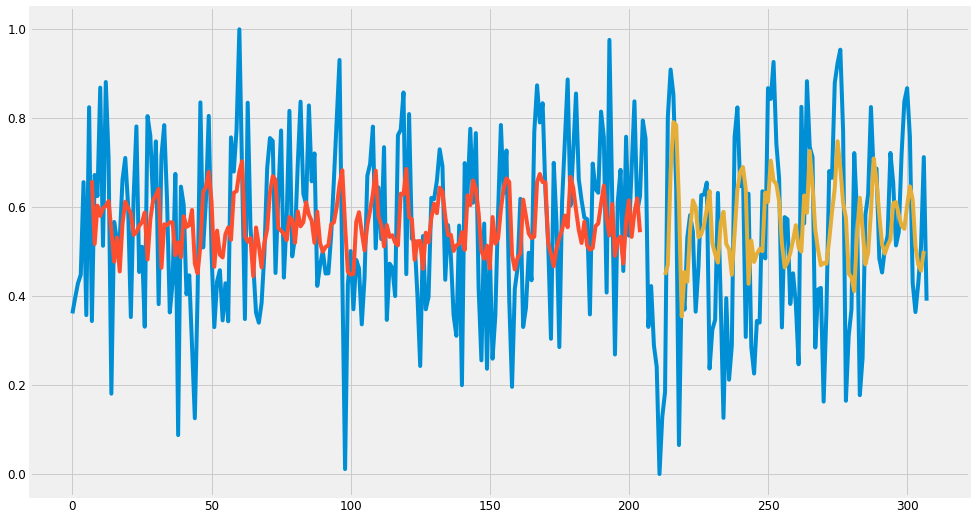

In [351]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15,9))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

LSTM for Regression with Time Steps

Epoch 1/100
 - 2s - loss: 0.0672
Epoch 2/100
 - 1s - loss: 0.0338
Epoch 3/100
 - 1s - loss: 0.0339
Epoch 4/100
 - 1s - loss: 0.0340
Epoch 5/100
 - 1s - loss: 0.0336
Epoch 6/100
 - 1s - loss: 0.0336
Epoch 7/100
 - 1s - loss: 0.0334
Epoch 8/100
 - 1s - loss: 0.0333
Epoch 9/100
 - 1s - loss: 0.0335
Epoch 10/100
 - 1s - loss: 0.0335
Epoch 11/100
 - 1s - loss: 0.0335
Epoch 12/100
 - 1s - loss: 0.0333
Epoch 13/100
 - 1s - loss: 0.0335
Epoch 14/100
 - 1s - loss: 0.0334
Epoch 15/100
 - 1s - loss: 0.0334
Epoch 16/100
 - 1s - loss: 0.0338
Epoch 17/100
 - 1s - loss: 0.0333
Epoch 18/100
 - 1s - loss: 0.0335
Epoch 19/100
 - 1s - loss: 0.0331
Epoch 20/100
 - 1s - loss: 0.0334
Epoch 21/100
 - 1s - loss: 0.0334
Epoch 22/100
 - 1s - loss: 0.0329
Epoch 23/100
 - 1s - loss: 0.0335
Epoch 24/100
 - 1s - loss: 0.0332
Epoch 25/100
 - 1s - loss: 0.0331
Epoch 26/100
 - 1s - loss: 0.0331
Epoch 27/100
 - 1s - loss: 0.0334
Epoch 28/100
 - 1s - loss: 0.0328
Epoch 29/100
 - 1s - loss: 0.0334
Epoch 30/100
 - 1s - lo

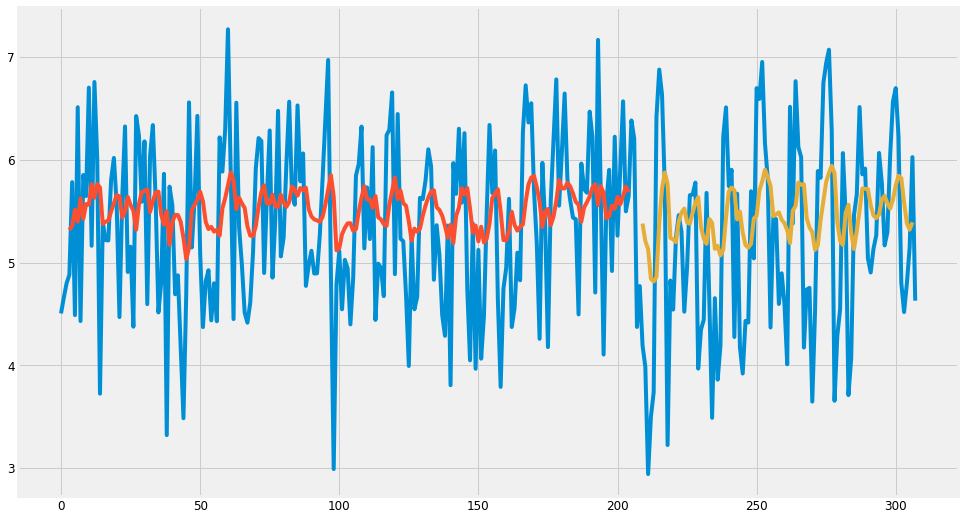

In [353]:
import numpy
dataset = new_df.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15,9))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()